In [29]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import imageio
import os 
import scipy.stats as stats 


In [30]:
plots_folder = "/Users/alexandranava/Desktop/EmbryonicCells/Plots/"

#Parameters
env_r = 5
num_cells = 2
Tsim = 120 #number of minutes to run simulation
dt = 10 # minutes between each simulation step 
N = int(Tsim/dt) # Number of iterations to run 
noise_std = 0.1
print(f"running {N} simulations...")
k = 7.5
theta = 10
A1, A2 = [-1, -1]

running 12 simulations...


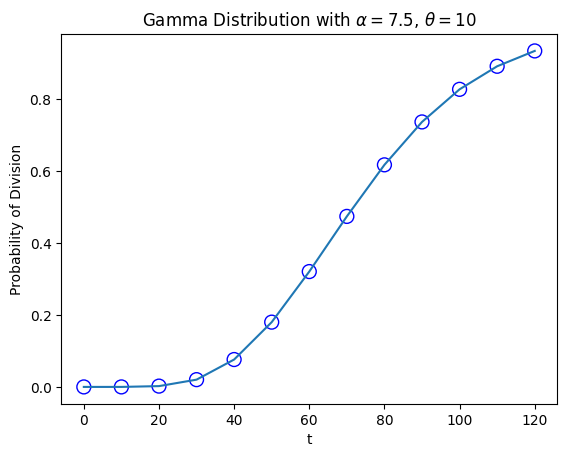

In [31]:
def plot_division_prob(k, theta, Tsim, dt):
  ts = np.arange(0, Tsim + dt, dt)
  distribution = stats.gamma.cdf(ts, a = k, scale = theta)
  plt.plot(ts, distribution)

  plt.scatter(ts, distribution, facecolors='none', edgecolors='b', s=100)
  
  plt.xlabel("t")
  plt.ylabel("Probability of Division")
  plt.title(rf"Gamma Distribution with $\alpha = {k}$, $\theta = {theta}$")
  return max(distribution)
max_prob = plot_division_prob(k, theta, Tsim, dt)

In [32]:
def is_in_boundary(cell_position: list[int], r_env = 5):
  '''
  Parameters: 
  r: radius of defined region for cells
  cell_position: list for a single cell with x and y position
  Return: 
  true: within region
  false: exited region
  '''
  x = cell_position[0]
  y = cell_position[1]

  if np.sqrt(x**2 + y**2) < r_env:
    return True
  else: 
    return False

def calculate_cartesian_coords(theta, r):
  cos = np.cos(theta)
  sin = np.sin(theta)
  x = cos*r
  y = sin*r
  return [x, y]

def calculate_polar_coords(x, y):
  r = np.sqrt(x**2 + y**2)
  theta = np.arctan2(y, x)
  return [theta, r]

In [33]:
# labeling for cells 
num_cells_sp1 = 1 #number of cells in species 1
num_cells_sp2 = 1 # number of cells in species 2
cell_ids_1 = ["o_" + str(cell_id) for cell_id in range(num_cells_sp1)] # unique ids for each cell in species 1 with species identifier
cell_ids_2 = ["t_" + str(cell_id) for cell_id in range(num_cells_sp2)] # unique ids for each cell in species 2 with species identifier
cell_ids = cell_ids_1 + cell_ids_2
species = ["one", "two"]

#initialize angle 
cell_theta_init = [random.uniform(0, 360) for _ in range(len(cell_ids))]
#initialize distance from origin
cell_dist_init = [random.uniform(0, env_r) for _ in range(len(cell_ids))]

coordinates = [calculate_cartesian_coords(theta, dist) for theta, dist in zip(cell_theta_init, cell_dist_init)]
xs_init, ys_init = zip(*coordinates)

df = pd.DataFrame({
    'species': species,
    'cell_ids': cell_ids,
    't': [0] * len(cell_ids),
    'x': xs_init,
    'y': ys_init
})

In [34]:
def sp_attracting(t, cell_ids: list[str], attraction_coefs: list[float]):
  '''behavior of different species attracting/repelling'''

  # cell ids and attraction to eachother
  cell_sp1, cell_sp2 = cell_ids
  coef_sp1, coef_sp2 = attraction_coefs  # Coefficients for sp1 -> sp2 and sp2 -> sp1
  # angle of each from original, and distance from origin
  
  print("cell" + cell_sp1)
  print("t" + str(t))
  print(df)

  x_sp1 = df.loc[(df['cell_ids'] == cell_sp1) & (df['t'] == t), 'x'].values[0]
  y_sp1 = df.loc[(df['cell_ids'] == cell_sp1) & (df['t'] == t), 'y'].values[0]
  x_sp2 = df.loc[(df['cell_ids'] == cell_sp2) & (df['t'] == t), 'x'].values[0]
  y_sp2 = df.loc[(df['cell_ids'] == cell_sp2) & (df['t'] == t), 'y'].values[0]

  #distance used for normalization
  distance = np.sqrt((x_sp2 - x_sp1)**2 + (y_sp2 - y_sp1)**2)
  # normalized direction vector from sp1 to sp2

  x_direction_sp1 = (x_sp2 - x_sp1) / distance
  y_direction_sp1 = (y_sp2 - y_sp1) / distance

  x_direction_sp2 = (x_sp1 - x_sp2) / distance
  y_direction_sp2 = (y_sp1 - y_sp2) / distance

  #new coordinates 
  x_sp1_next = x_sp1 + coef_sp1 * x_direction_sp1 + np.random.normal(0, noise_std)
  y_sp1_next = y_sp1 + coef_sp1 * y_direction_sp1 + np.random.normal(0, noise_std)
  
  if is_in_boundary([x_sp1_next, y_sp1_next]) == False: 
    x_sp1_next, y_sp1_next = x_sp1, y_sp1

  x_sp2_next = x_sp2 + coef_sp2 * x_direction_sp2 + np.random.normal(0, noise_std)
  y_sp2_next = y_sp2 + coef_sp2 * y_direction_sp2 + np.random.normal(0, noise_std)

  if is_in_boundary([x_sp2_next, y_sp2_next]) == False: 
    x_sp2_next, y_sp2_next = x_sp2, y_sp2

  return [x_sp1_next, y_sp1_next], [x_sp2_next, y_sp2_next]

def cell_division(k, theta, t, max_prob):
  prob_t = stats.gamma.pdf(t, a = k, scale = theta)
  random = np.random.uniform(0, max_prob) # between 0 and 1
  return prob_t > random

new_rows = []

for i in range(N):
    print(f"\nSimulating timestep {i}...")
    for cell in df["cell_ids"].unique():
      if cell_division(k, theta, i, max_prob):
        # Generate new cell ID for split cell
        base_id = cell.split("_")[0]
        new_cell_id = base_id + "_" + str(len(df["cell_ids"].unique()))

        x_cell = df.loc[(df['cell_ids'] == cell) & (df['t'] == i -1), 'x'].values[0]
        y_cell = df.loc[(df['cell_ids'] == cell) & (df['t'] == i -1), 'y'].values[0]
        species = df.loc[df['cell_ids'] == cell, 'species'].values[0]
        new_cell = ({
            "cell_ids": new_cell_id,
            "t": i,
            "species": species, 
            "x": x_cell,
            "y": y_cell,
            "parent cell": cell
        })
        print(f"Cell {cell} divided, new cell {new_cell_id} added at timestep {i}")
        df.loc[len(df)] = new_cell


    for cell_sp1 in df["cell_ids"].unique():
        for cell_sp2 in df["cell_ids"].unique():
            
            if cell_sp1 == cell_sp2:
                continue
            
            species_sp1 = df.loc[df['cell_ids'] == cell_sp1, 'species'].values[0]
            species_sp2 = df.loc[df['cell_ids'] == cell_sp2, 'species'].values[0]
            if species_sp1 == species_sp2: 
               continue
            
            print(f"working on {cell_sp1} and {cell_sp2}...")
            # Initial positions are only needed at the first timestep
            if not df[(df['cell_ids'] == cell_sp1) & (df['t'] == i)].empty:
                x_sp1 = df.loc[(df['cell_ids'] == cell_sp1) & (df['t'] == i), 'x'].values[0]
                y_sp1 = df.loc[(df['cell_ids'] == cell_sp1) & (df['t'] == i), 'y'].values[0]

            # Check if data exists for cell_sp2 at the current time step i
            if not df[(df['cell_ids'] == cell_sp2) & (df['t'] == i)].empty:
                x_sp2 = df.loc[(df['cell_ids'] == cell_sp2) & (df['t'] == i), 'x'].values[0]
                y_sp2 = df.loc[(df['cell_ids'] == cell_sp2) & (df['t'] == i), 'y'].values[0]
                    

            [x_sp1_next, y_sp1_next], [x_sp2_next, y_sp2_next] = sp_attracting(i, [cell_sp1, cell_sp2], [A1, A2])
            
            df.loc[len(df)] = ({'cell_ids': cell_sp1, 't': i+1, 'x': x_sp1_next, 'y': y_sp1_next, "species": species_sp1})
            df.loc[len(df)] = ({'cell_ids': cell_sp2, 't': i+1, 'x': x_sp2_next, 'y': y_sp2_next, "species": species_sp2})



Simulating timestep 0...
working on o_0 and t_0...
cello_0
t0
  species cell_ids  t         x         y
0     one      o_0  0 -1.190204  0.015738
1     two      t_0  0  1.871599  3.320258
working on t_0 and o_0...
cellt_0
t0
  species cell_ids  t         x         y
0     one      o_0  0 -1.190204  0.015738
1     two      t_0  0  1.871599  3.320258
2     one      o_0  1 -1.919071 -0.713081
3     two      t_0  1  2.478528  4.155383

Simulating timestep 1...
working on o_0 and t_0...
cello_0
t1
  species cell_ids  t         x         y
0     one      o_0  0 -1.190204  0.015738
1     two      t_0  0  1.871599  3.320258
2     one      o_0  1 -1.919071 -0.713081
3     two      t_0  1  2.478528  4.155383
4     two      t_0  1  2.459401  3.984084
5     one      o_0  1 -1.881706 -0.713891
working on t_0 and o_0...
cellt_0
t1
  species cell_ids  t         x         y
0     one      o_0  0 -1.190204  0.015738
1     two      t_0  0  1.871599  3.320258
2     one      o_0  1 -1.919071 -0.713081
3 

In [35]:
def embryos_gif():
    frames = []
    for t in range(N+1):
        plt.figure(figsize=(10, 8))
        plt.axvline(0, linestyle="--", color="lightgrey")
        plt.axhline(0, linestyle="--", color="lightgrey")
        plt.xlim(-env_r, env_r)
        plt.ylim(-env_r, env_r)
        
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("X Position", fontsize=18)
        plt.ylabel("Y Position", fontsize=18)

        # Plot scatter for current frame (time step `t`)
        sns.scatterplot(x="x", y="y", data=df[df["t"] <= t], hue="species", palette="pastel", s=60, edgecolor="w", legend=None)
        sns.scatterplot(data=df[df['t'] == 0], x='x', y='y', marker="*", color="black", label='Initial', s=80)
        sns.scatterplot(data=df[df['t'] == t], x='x', y='y', marker='x', color='black', label='Current', s=80)
        
        boundary = plt.Circle((0, 0), env_r, edgecolor='black', facecolor='none', linewidth=2, label = "experiment boundary")
        plt.gca().add_patch(boundary)

        plt.title(rf"$(A_1, A_2)$ = ({A1}, {A2}), Time = {t}", fontsize=18)
        plt.legend(loc="upper right", fontsize=14)

        # Save the frame and add it to the list
        filename = f"frame_{t}.png"
        plt.savefig(filename)
        plt.close()
        frames.append(filename)

    # gif 
    with imageio.get_writer(f'{plots_folder}attraction_(A1,A2)=({A1},{A2}).gif', mode='I', duration=0.5) as writer:
        for frame in frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    # remove saved frames 
    for frame in frames:
        os.remove(frame)

    print(f"GIF saved as scatter_animation.gif in {plots_folder}")
embryos_gif()

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_83412/1501278795.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


GIF saved as scatter_animation.gif in /Users/alexandranava/Desktop/EmbryonicCells/Plots/


### Cell Division
k: shape parameter, level of skew 
theta: stretch of distribution